In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
  return 3*x**2 - 4*x + 5


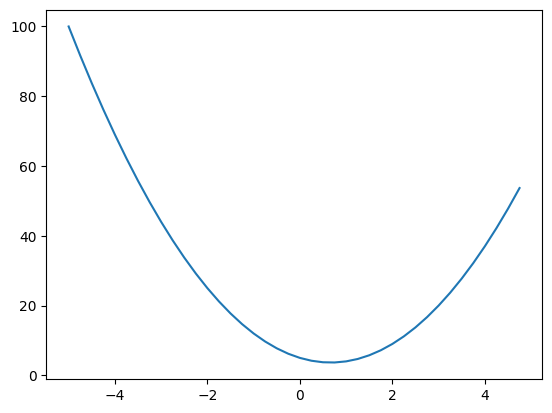

In [3]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [4]:
class Value:
  
    def __init__(self, data, _children=(), _op='', label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label 

    def __repr__(self):
        return f"Value(data={self.data})"
  
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other): # other + self
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
         
        out._backward = _backward 
        return out
    
    def __rmul__(self, other): # otherr * self
        return self * other
    
    def __pow__(self, other): ## self ** other
        assert isinstance(other, (int, float))
        out = Value(self.data**other, (self,), f'**{other}')
        def _backward():
            self.grad += ( other * ( self.data ** ( other-1 ) ) ) * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __sub__(self, other): # self - other
        return self + (-1*other)

    def __rsub__(self, other): # other - self
        return self - other

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0 
        for node in reversed(topo):
            node._backward()

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad +=  (1 - t**2) * out.grad
         
        out._backward = _backward 
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += math.exp(self.data) * out.grad
        out._backward = _backward 
        return out
  
a = Value(2.0, label='a')
b = Value(-3.0, label='d')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0 , label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [5]:
a = Value(2.0)
b = Value(4.0)
2 - a

Value(data=0.0)

In [6]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

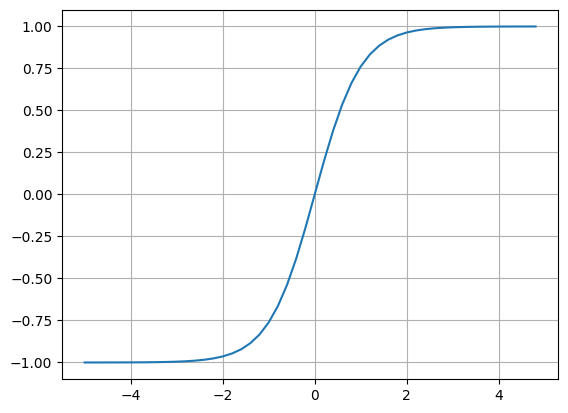

In [7]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [8]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()


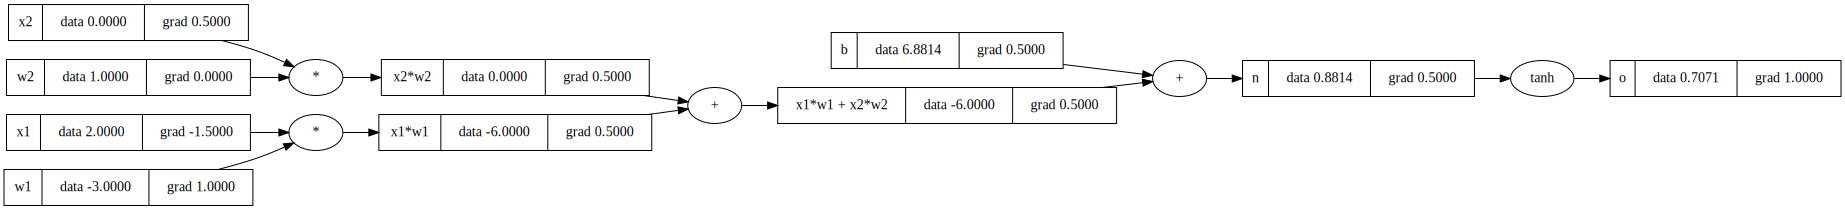

In [9]:
draw_dot(o)

In [10]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# --------
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ---------
o.label = 'o'
o.backward()

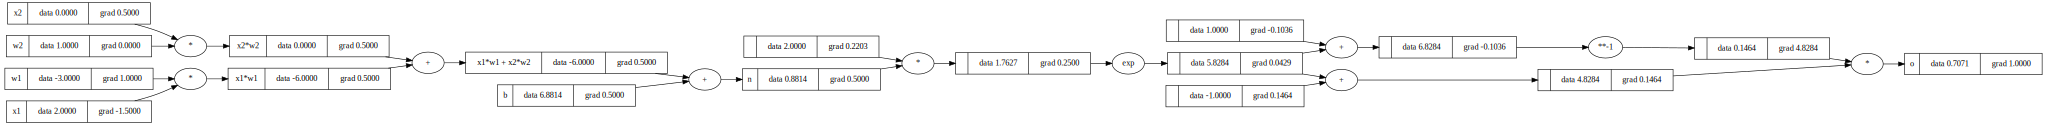

In [11]:
draw_dot(o)

In [12]:
import torch

In [13]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [22]:
import random
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
       return self.w + [self.b]
    
class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs)==1 else outs
  
  def parameters(self):
    params = []
    for neuron in self.neurons:
      ps = neuron.parameters()
      params.extend(ps)
    return params

  
class MLP:
  
  def __init__(self, nin, nouts):
    # nouts is an array of number of neurons in each layer
    sz = [nin] + nouts
    # print(sz)
    # print(sz[0])
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
     return [p for layer in self.layers for p in layer.parameters()]
  

In [88]:
x = [2.0, 3.0, -1.0] 
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.8681653449548057)

## Creating a dataset

In [89]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.8681653449548057),
 Value(data=0.6382686175175947),
 Value(data=0.46617862096260976),
 Value(data=-0.9352648844776802)]

In [96]:
for k in range(1000):
    
    # Forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # zero_grad()
    for p in n.parameters():
        p.grad = 0.0

    # Backward pass
    loss.backward()

    # Update
    for p in n.parameters():
        p.data += -0.1 * p.grad
    print(k, loss.data)

0 0.002742568389345978
1 0.0027161745654830987
2 0.0026902774826742587
3 0.002664863357427818
4 0.002639918908876623
5 0.0026154313361597204
6 0.002591388297011464
7 0.002567777887483029
8 0.0025445886227276537
9 0.0025218094187850074
10 0.002499429575304898
11 0.00247743875915408
12 0.0024558269888545294
13 0.002434584619804108
14 0.0024137023302344134
15 0.0023931711078632504
16 0.002372982237202153
17 0.0023531272874817524
18 0.002333598101160367
19 0.002314386782983001
20 0.0022954856895607803
21 0.002276887419441814
22 0.0022585848036467365
23 0.002240570896644271
24 0.002222838967742428
25 0.002205382492873955
26 0.002188195146754672
27 0.002171270795395382
28 0.002154603488948845
29 0.0021381874548745522
30 0.002122017091404819
31 0.0021060869612971487
32 0.002090391785858021
33 0.0020749264392247715
34 0.0020596859428923552
35 0.0020446654604733324
36 0.002029860292679096
37 0.0020152658725118176
38 0.0020008777606568963
39 0.0019866916410660198
40 0.0019727033167220758
41 0.00